# Stimulus Reconstruction with TRF model

This notebook demonstrates how to use the TRF model in ``naplib-python`` to do stimulus reconstruction from neural recordings. This is a technique where the auditory stimulus is reconstructed from the electrode responses. Here, we will train a linear TRF model to reconstruct the stimulus spectrogram using 250 ms of responses from a group of electrodes.

For more information on stimulus reconstruction and its uses, please see the following papers:

- Mesgarani, Nima, et al. "Influence of context and behavior on stimulus reconstruction from neural activity in primary auditory cortex." Journal of neurophysiology 102.6 (2009): 3329-3339. https://journals.physiology.org/doi/full/10.1152/jn.91128.2008

- Pasley, Brian N., et al. "Reconstructing speech from human auditory cortex." PLoS biology 10.1 (2012): e1001251. https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1001251


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample

import naplib as nl

In [2]:
# data = nl.io.load_speech_task_data()
data = nl.io.import_outstruct('../out_structs/demo_data.mat')
print(f'This data has {len(data)} trials')

In [3]:
# This data contains 48 electrodes of simultaneous recording
data['resp'][0].shape

(6197, 10)

In [4]:
# get auditory spectrogram for each stimulus sound
data['spec'] = [nl.features.auditory_spectrogram(trial['sound'], 11025) for trial in data]

# make sure the spectrogram is the exact same size as the responses
data['spec'] = [resample(trial['spec'], trial['resp'].shape[0]) for trial in data] 

In [5]:
data['resp'] = nl.preprocessing.normalize(data, 'resp')

In [6]:
# Since the spectrogram is 128-channels, which is very large, we downsample it
from scipy.signal import resample

print(f"before resampling: {data['spec'][0].shape}")

resample_kwargs = {'num': 32, 'axis': 1}
data['spec_32'] = nl.array_ops.concat_apply(data['spec'], resample, function_kwargs=resample_kwargs)

print(f"after resampling:  {data['spec_32'][0].shape}")


before resampling: (6197, 128)
after resampling:  (6197, 32)


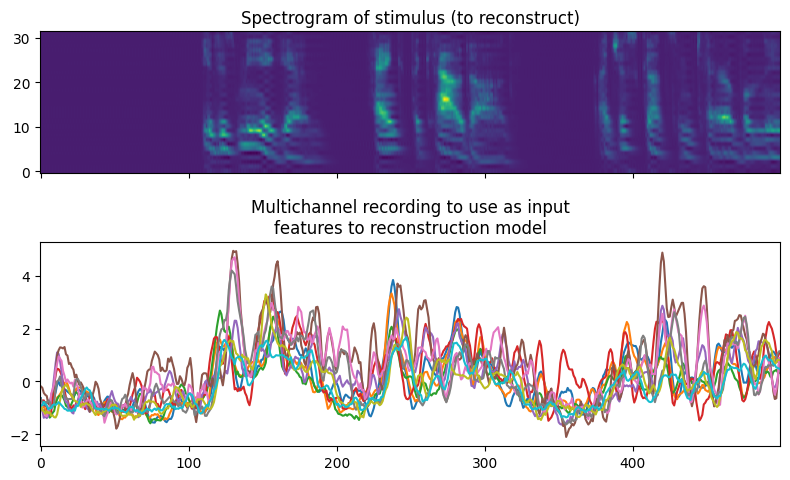

In [7]:
# Let's look at the first 5 seconds more closely to understand the data

fig, axes = plt.subplots(2,1,figsize=(8,5), sharex=True)
axes[0].imshow(data[0]['spec_32'][:500].T, aspect=3, origin='lower')
axes[0].set_title('Spectrogram of stimulus (to reconstruct)')
axes[1].plot(data[0]['resp'][:500])
axes[1].set_title('Multichannel recording to use as input\nfeatures to reconstruction model')
plt.tight_layout()
plt.show()


## Train single TRF model to reconstruct all frequency bins as a single output channel with multiple dimensions

First, we reshape the stimulus spectrograms to be (time * 1 * frequency), because if they are just (time * frequency), then a separate model will be trained for each frequency bin

In [11]:
data['reshaped_spec'] = [x[:,np.newaxis,:] for x in data['spec_32']]
print(data['reshaped_spec'][0].shape)

(6197, 1, 32)


In [12]:
# separate into train and test sections
data_train = data[1:]
data_test = data[:1]


In [13]:
# model parameters
tmin = -0.40 # 400 ms window from the neural response is used to reconstruct the next time sample of the stimulus
tmax = 0
sfreq = 100

In [31]:
# train model with default Ridge estimator
mdl = nl.encoding.TRF(tmin=tmin, tmax=tmax, sfreq=sfreq)
mdl.fit(data_train, X='resp', y='reshaped_spec')


  0%|          | 0/1 [00:00<?, ?it/s]

TRF(estimator=RidgeCV(alphas=array([1.00000000e-02, 2.51188643e-01, 6.30957344e+00, 1.58489319e+02,
       3.98107171e+03, 1.00000000e+05]),
                      cv=5),
    sfreq=100.0, tmax=0, tmin=-0.4)

In [32]:
reconstructed_stims = mdl.predict(data_test, X='resp')
reconstructed_stims[0].shape

(6197, 1, 32)

In [33]:
# compute correlation score
corr = mdl.corr(data_test, X='resp', y='reshaped_spec')

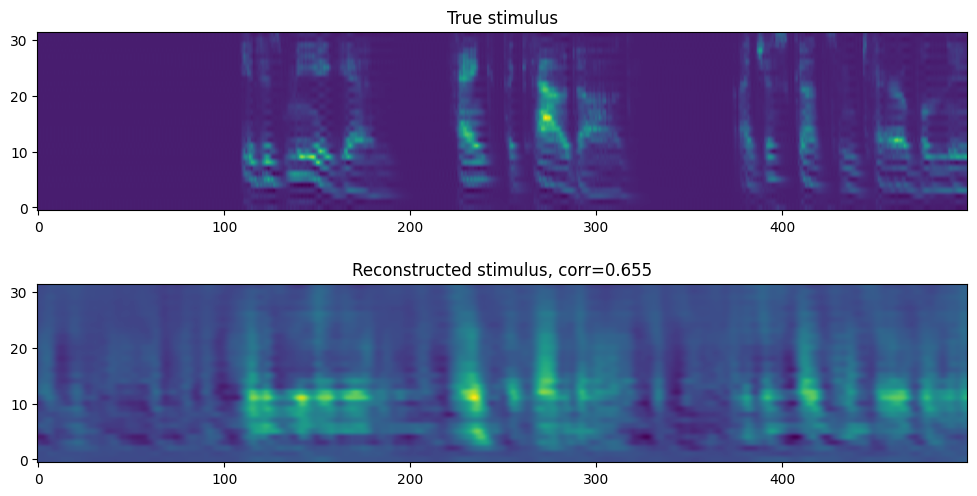

In [34]:
region = slice(0, 500)

fig, axes = plt.subplots(2,1,figsize=(12,6))

axes[0].imshow(data_test[0]['reshaped_spec'].squeeze()[region].T, aspect=3, origin='lower')
axes[0].set_title('True stimulus')
axes[1].imshow(reconstructed_stims[0].squeeze()[region].T, aspect=3, origin='lower')
axes[1].set_title('Reconstructed stimulus, corr={:.3f}'.format(corr.item()))

plt.show()

## Train a TRF model to reconstruct each frequency bin individually

For this, we can use the spectrogram which is shape (time * frequency), instead of the reshaped spectrogram, since the TRF model will automatically train a single model for each channel in the second dimension of the `y` variable.

In [21]:
# train model
mdl = nl.encoding.TRF(tmin=tmin, tmax=tmax, sfreq=sfreq)
mdl.fit(data_train, X='resp', y='spec_32')


  0%|          | 0/32 [00:00<?, ?it/s]

TRF(estimator=RidgeCV(alphas=array([1.00000000e-02, 2.51188643e-01, 6.30957344e+00, 1.58489319e+02,
       3.98107171e+03, 1.00000000e+05]),
                      cv=5),
    sfreq=100.0, tmax=0, tmin=-0.4)

In [24]:
reconstructed_stims_bychannel = mdl.predict(data_test, X='resp')
reconstructed_stims_bychannel[0].shape

(6197, 32)

In [29]:
# compute correlation score
corr = mdl.corr(data_test, X='resp', y='spec_32').mean()

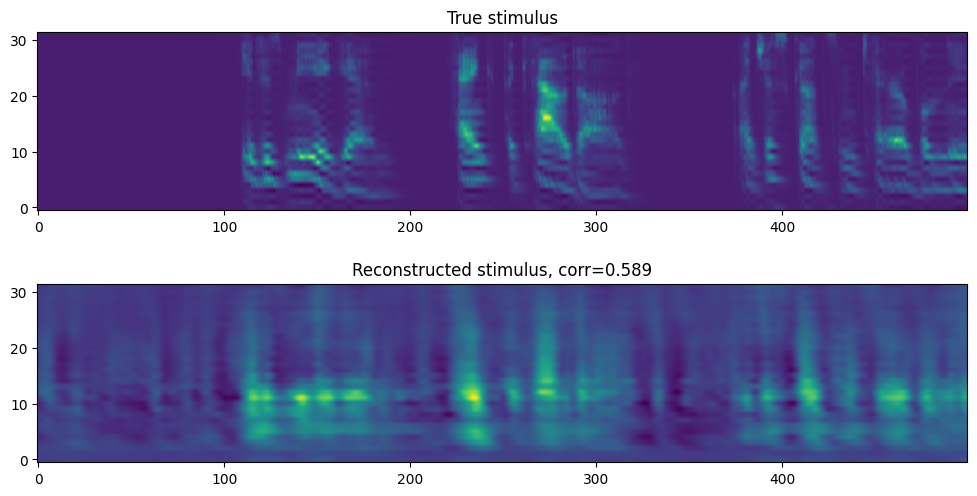

In [30]:
region = slice(0, 500)

fig, axes = plt.subplots(2,1,figsize=(12,6))

axes[0].imshow(data_test[0]['spec_32'].squeeze()[region].T, aspect=3, origin='lower')
axes[0].set_title('True stimulus')
axes[1].imshow(reconstructed_stims_bychannel[0].squeeze()[region].T, aspect=3, origin='lower')
axes[1].set_title('Reconstructed stimulus, corr={:.3f}'.format(corr))

plt.show()